# __Long Short Term Memory Decoder - _predict___

### __Deep Learning__

#### __Project: Image Captioning with Visual Attention__

In [1]:
import os
os.chdir(os.environ["PYTHONPATH"])

import torch
import torchvision
import matplotlib.pyplot as plt

import scripts.data_loading as dl
import scripts.data_processing as dp
from scripts import model

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (6, 6)

In [2]:
root = dl.DATASET_PATHS[dl.DatasetType.VALIDATION].images
ann_json = dl.DATASET_PATHS[dl.DatasetType.VALIDATION].captions_json

vocabulary = dp.Vocabulary()

coco_val = torchvision.datasets.CocoCaptions(root, ann_json, dp.VGGNET_PREPROCESSING_PIPELINE)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [3]:
img, captions = coco_val[123]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


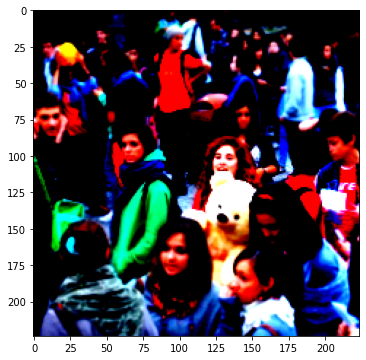

In [4]:
plt.imshow(img.permute(1, 2, 0))

In [5]:
captions

['A crowd of people standing around each other.',
 'Someone is holding a large teddy bear in the crowd.',
 'A group of men and women gathered together outside. ',
 'A large crowd of people walking around while one owns a teddy bear.',
 'A large group of people on a city street.']

In [6]:
preprocessed_captions = []
for caption in captions:
    preprocessed_caption = dp.TextPipeline.normalize(caption).split()
    preprocessed_captions.append(preprocessed_caption)

In [7]:
print(preprocessed_captions)

[['a', 'crowd', 'of', 'people', 'standing', 'around', 'each', 'other'], ['someone', 'is', 'holding', 'a', 'large', 'teddy', 'bear', 'in', 'the', 'crowd'], ['a', 'group', 'of', 'men', 'and', 'women', 'gathered', 'together', 'outside'], ['a', 'large', 'crowd', 'of', 'people', 'walking', 'around', 'while', 'one', 'owns', 'a', 'teddy', 'bear'], ['a', 'large', 'group', 'of', 'people', 'on', 'a', 'city', 'street']]


In [8]:
encoder = model.VGG19Encoder()
decoder = model.LSTMDecoder(
    num_embeddings=len(vocabulary),
    embedding_dim=8,
    encoder_dim=196,
    decoder_dim=16,
    attention_dim=4
)

In [9]:
feature_maps, feature_mean = encoder.forward(img.unsqueeze(0))

In [10]:
sequence, contexts = decoder.greedy_decoding(
    feature_maps=feature_maps,
    feature_mean=feature_mean,
    start_token_index=vocabulary.word2idx("<SOS>"),
    end_token_index=vocabulary.word2idx("<EOS>"),
    max_length=5
)

In [11]:
print(sequence)

[4610, 2461, 8651, 5040, 4426]


In [12]:
dp.TextPipeline.decode_caption(vocabulary, sequence)

'mailbox followed blinder upcoming aiming'

In [13]:
len(contexts)

5

In [14]:
for context in contexts:
    print(context.shape)

torch.Size([196])
torch.Size([196])
torch.Size([196])
torch.Size([196])
torch.Size([196])


In [15]:
print(len(coco_val))

5000


In [16]:
import time

start = time.time()

SOS_INDEX = vocabulary.word2idx("<SOS>")
EOS_INDEX = vocabulary.word2idx("<EOS>")

for image, captions in coco_val:
    
    preprocessed_captions = []
    for caption in captions:
        preprocessed_captions.append(dp.TextPipeline.normalize(caption).split())    
    
    feature_maps, feature_mean = encoder.forward(image.unsqueeze(0))
            
    sequence, contexts = decoder.greedy_decoding(
        feature_maps=feature_maps,
        feature_mean=feature_mean,
        start_token_index=SOS_INDEX,
        end_token_index=EOS_INDEX,
        max_length=15
    )
    
time.time() - start

1240.857434272766

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device {torch.cuda.get_device_name(device.index)}")

encoder.to(device)
decoder.to(device)

start = time.time()

SOS_INDEX = vocabulary.word2idx("<SOS>")
EOS_INDEX = vocabulary.word2idx("<EOS>")

for image, captions in coco_val:
    preprocessed_captions = []
    for caption in captions:
        preprocessed_captions.append(dp.TextPipeline.normalize(caption).split())    
    
    image = image.to(device)
    
    feature_maps, feature_mean = encoder.forward(image.unsqueeze(0))    
        
    sequence, contexts = decoder.greedy_decoding(
        feature_maps=feature_maps,
        feature_mean=feature_mean,
        start_token_index=SOS_INDEX,
        end_token_index=EOS_INDEX,
        max_length=15
    )
    
time.time() - start

Training on device GeForce GTX 960M
